# Image matching 

Very simple example to match images with reference ones.

Idea is to use a feature detector and to store reference image feature and compare with test images

In [1]:
import numpy as np
import matplotlib.pylab as plt
import cv2
%matplotlib inline

In [2]:
ref_image_file_1 = "data/ref_images/ref_1.JPG"
ref_image_file_2 = "data/ref_images/ref_2.JPG"

Load and display reference images

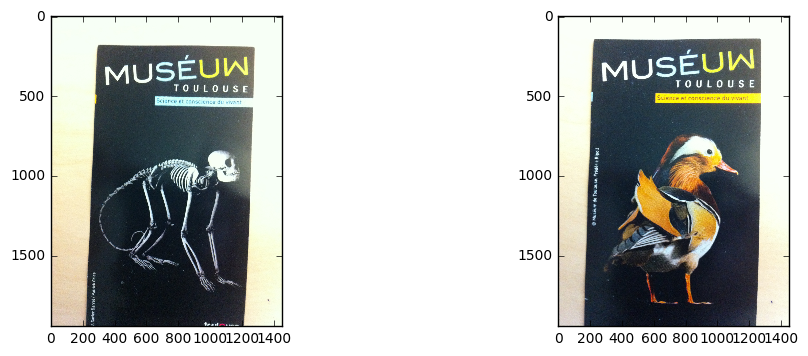

In [3]:
ref_image_1 = cv2.imread(ref_image_file_1)
ref_image_2 = cv2.imread(ref_image_file_2)

assert ref_image_1 is not None and ref_image_2 is not None, "Error: Images are not loaded"

def transform_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return cv2.resize(img, (0, 0), fx=0.75, fy=0.75)
    
ref_image_1 = transform_image(ref_image_1)
ref_image_2 = transform_image(ref_image_2)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(ref_image_1)
plt.subplot(122)
plt.imshow(ref_image_2)

Initialize ORB feature detector. For more info see this [link](http://docs.opencv.org/3.1.0/db/d95/classcv_1_1ORB.html#details). Then find key points and compute descriptors for the reference images

In [25]:
# Initiate ORB detector
orb = cv2.ORB_create(nfeatures=1000)

# find the keypoints with ORB
ref_keypoints_1 = orb.detect(ref_image_1, None)
ref_keypoints_2 = orb.detect(ref_image_2, None)

# compute the descriptors with ORB
ref_keypoints_1, ref_descriptors_1 = orb.compute(ref_image_1, ref_keypoints_1)
ref_keypoints_2, ref_descriptors_2 = orb.compute(ref_image_2, ref_keypoints_2)

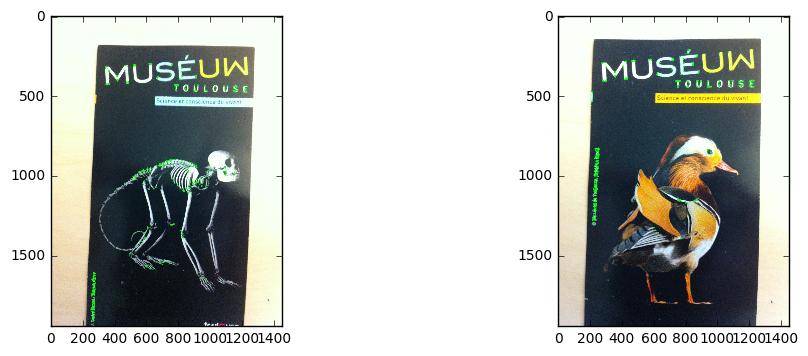

In [26]:
# draw only keypoints location,not size and orientation
plt.figure(figsize=(12,4))
for i, kp, img in zip([1,2], [ref_keypoints_1, ref_keypoints_2], [ref_image_1, ref_image_2]):
    img = cv2.drawKeypoints(img, kp, img, color=(0,255,0), flags=0)
    plt.subplot(1,2,i)
    plt.imshow(img)

Thus, we found :

In [27]:
print len(ref_keypoints_1), ref_descriptors_1.shape
print len(ref_keypoints_2), ref_descriptors_2.shape

1000 (1000, 32)
1000 (1000, 32)


In [28]:
ref_features = {
    'ref_1': [ref_keypoints_1, ref_descriptors_1],
    'ref_2': [ref_keypoints_2, ref_descriptors_2]
}

Now we can load test images and verify whether we match images with the reference ones

In [29]:
import os
test_images = []
for filename in os.listdir('data'):
    p = os.path.join('data', filename)
    if not os.path.isfile(p):
        continue
    img = cv2.imread(p)
    img = transform_image(img)
    test_images.append(img)

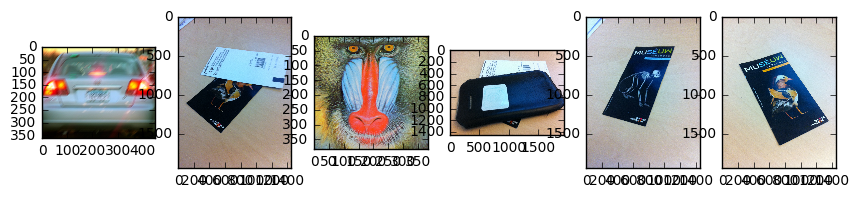

In [30]:
plt.figure(figsize=(12,4))
ll = len(test_images)
for i, img in enumerate(test_images):
    plt.subplot(1,ll+1,i+1)
    plt.imshow(img)

To match descriptors we will use a brute-force matcher. A matcher gives a list of matches characterized by a distance (Hamming in case of ORB descriptors). At first, let us make an intuition on the Hamming distance. Following the [wiki](https://en.wikipedia.org/wiki/Hamming_distance) : 

> In information theory, the Hamming distance between two strings of equal length is the number of positions at which the corresponding symbols are different. In another way, it measures the minimum number of substitutions required to change one string into the other, or the minimum number of errors that could have transformed one string into the other.

In the [code](https://github.com/opencv/opencv/blob/master/modules/core/include/opencv2/core/base.hpp) of OpenCV, we find that : 

```
/*
 * Hamming distance functor - counts the bit differences between two strings - useful for the Brief descriptor
 * bit count of A exclusive XOR'ed with B
 */
```

In [31]:
a = np.array([1,1,1,1,1,255], dtype=np.uint8)
b = np.array([1,1,1,1,1,0], dtype=np.uint8)
print cv2.norm(a, b, cv2.NORM_HAMMING), (a ^ b)

8.0 [  0   0   0   0   0 255]


Check how two reference images are different

In [32]:
dist = []
for d1 in ref_descriptors_1:
    for d2 in ref_descriptors_2:
        dist.append(cv2.norm(d1, d2, cv2.NORM_HAMMING))
print "Min/Max : ", np.min(dist), np.max(dist)

Min/Max :  11.0 219.0


Raw feature matching gives something weird, however fixing a threshold on the match distance, we can findout similar features.

<function __main__.interactive_matches>

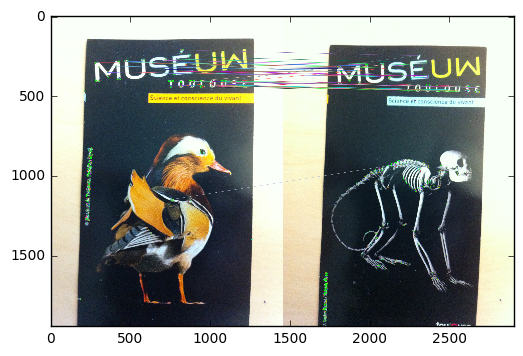

In [33]:
from ipywidgets import interact, FloatSlider

matcher = cv2.BFMatcher(cv2.NORM_HAMMING)
raw_ref_matches = matcher.match(ref_features['ref_2'][1], ref_features['ref_1'][1])

def interactive_matches(threshold):
    matches = []
    for m in raw_ref_matches:
        if m.distance < threshold:
            matches.append(m)
    out = np.array([])
    out = cv2.drawMatches(ref_image_2, ref_keypoints_2, ref_image_1, ref_keypoints_1, matches, out)
    plt.imshow(out)  


interact(interactive_matches, 
          threshold=FloatSlider(value=30.0, min=0.0, max=50.0, continuous_update=False))

Now, we check test images. We accept a match between images whether a percentage of reference keypoints is matched.

In [34]:
matcher = cv2.BFMatcher(cv2.NORM_HAMMING)

Score =  0 1000
Score =  0 1000
0 0
Score =  6 1000
Score =  6 1000
6 6
Score =  1 1000
Score =  1 1000
1 1
Score =  0 1000
Score =  0 1000
0 0
Score =  33 1000
Score =  33 1000
33 33
Score =  22 1000
Score =  22 1000
22 22


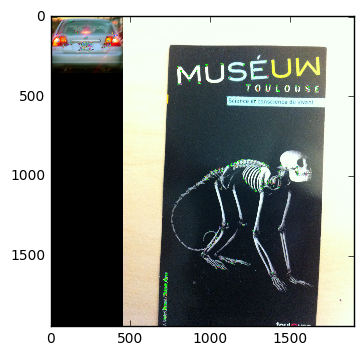

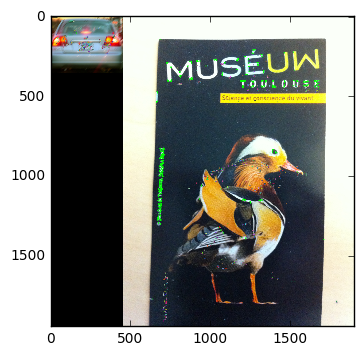

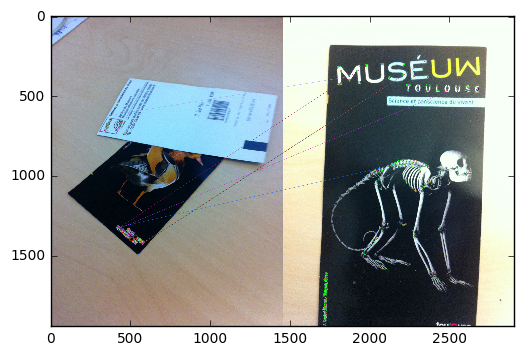

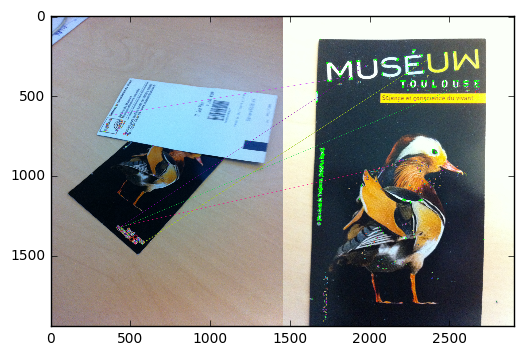

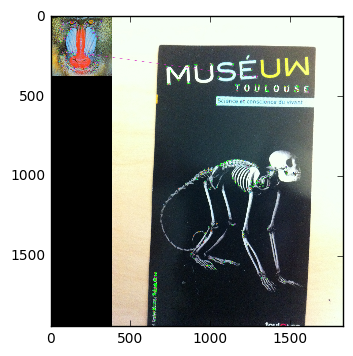

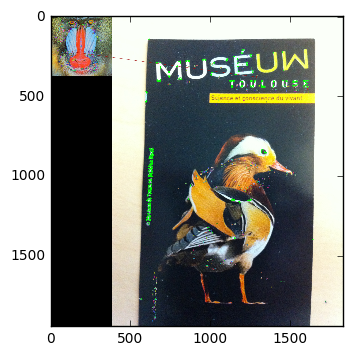

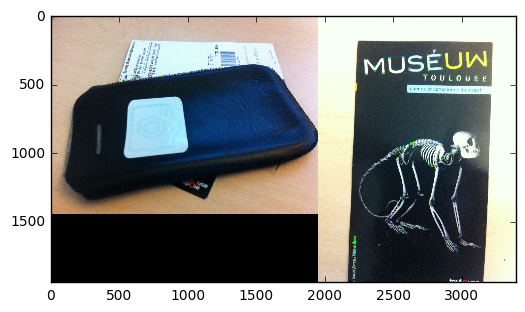

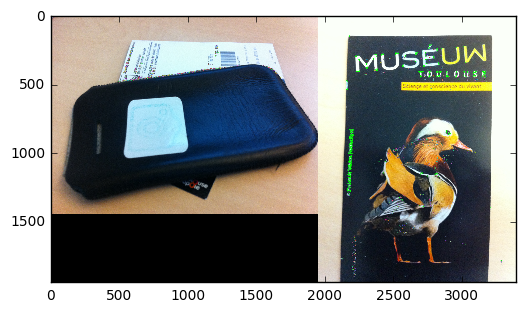

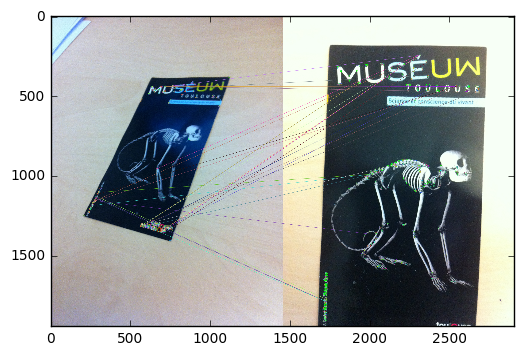

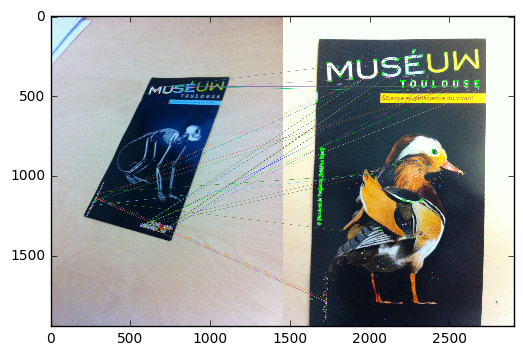

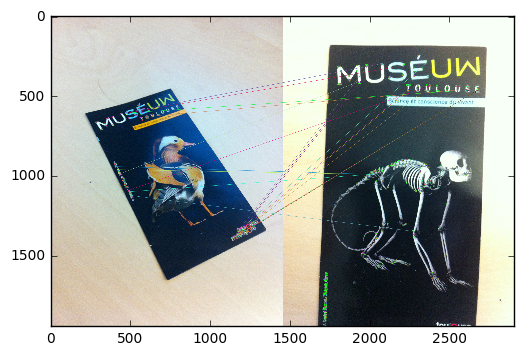

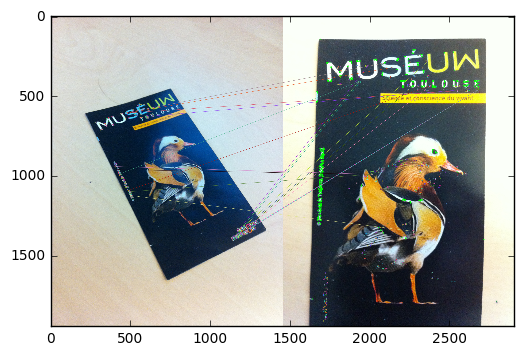

In [37]:
verbose = True
threshold = 35.0

def match_ref(img, kp, ref_image, ref_key, threshold, verbose):
    # Match with the 1st ref image : 
    ref_desc = ref_features[ref_key][1]
    raw_matches = matcher.match(desc, ref_desc)
    # Select matches with the distance higher than a threshold
    matches = [m for m in raw_matches if m.distance < threshold]
    score = len(matches)*1.0/len(ref_desc)
    print "Score = ", len(matches), len(ref_desc)
    if verbose:
        out = np.array([])
        out = cv2.drawMatches(img, kp, ref_image, ref_features[ref_key][0], matches, out)
        plt.figure()
        plt.imshow(out) 
    return len(matches)

for i, img in enumerate(test_images):
    kp = orb.detect(img, None)
    # compute the descriptors with ORB
    kp, desc = orb.compute(img, kp)
    
    score1 = match_ref(img, kp, ref_image_1, 'ref_1', threshold, verbose)
    score2 = match_ref(img, kp, ref_image_2, 'ref_1', threshold, verbose)
    print score1, score2